Task: Movie review classification

Dataset: IMDB https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Model: BERT

Libraries: Pytorch, HuggingFace

Reference: https://medium.com/@pyroswolf200/fine-tuning-bert-on-imdb-review-dataset-309e90b6dac0

# Libraries

In [1]:
# %%capture
# !pip install wget
# !pip install transformers
# !pip install lightning

In [2]:
import pandas as pd
import re
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import numpy as np


# Config

In [3]:
INPUT_CSV_PATH = "IMDB Dataset.csv" #"/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"
EPOCHS = 5
BATCH_SIZE = 32
MAX_SEQ_LEN = 64
FAST_DEV_RUN = False
TOTAL_SAMPLES= 500

In [4]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'{torch.cuda.device_count()} GPU(s) available. Using the GPU: {torch.cuda.get_device_name(0)}')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Mac ARM64 GPU")
else:
    device = torch.device("cpu")
    print('No GPU available, using CPU')

1 GPU(s) available. Using the GPU: NVIDIA GeForce RTX 3050 Laptop GPU


# Dataset

In [5]:
df = pd.read_csv(INPUT_CSV_PATH)
df = df.head(TOTAL_SAMPLES)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.sentiment = [1 if s == 'positive' else 0 for s in df.sentiment]
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))

<Axes: ylabel='count'>

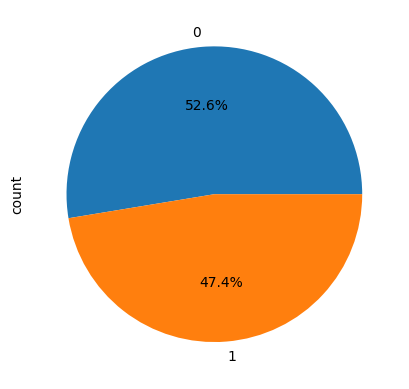

In [7]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [8]:
[int(.8*len(df)), int(.9*len(df))]

[400, 450]

In [9]:
train, val, test = np.split(df.sample(frac=1, random_state=42), 
                       [int(.8*len(df)), int(.9*len(df))])
print(len(train), len(val), len(test))

400 50 50


c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


<Axes: ylabel='count'>

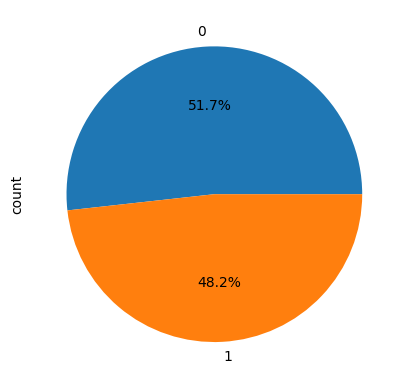

In [10]:
train['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')

<Axes: ylabel='count'>

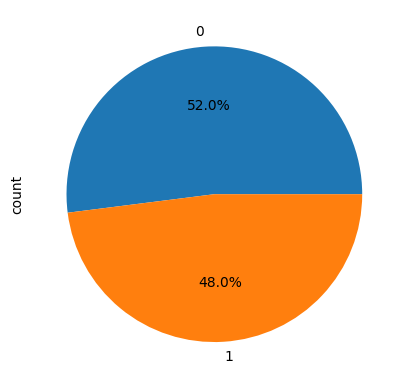

In [11]:
val['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')

<Axes: ylabel='count'>

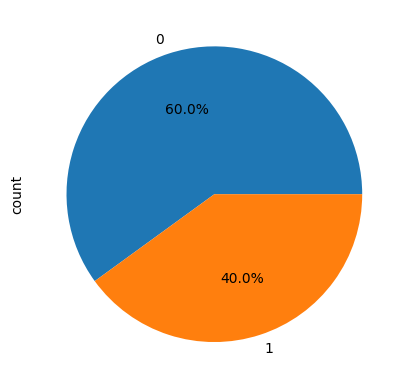

In [12]:
test['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%')

In [13]:
# Get the lists of sentences and their labels.
train_sentences = train.review.values
train_labels = train.sentiment.values
val_sentences = val.review.values
val_labels = val.sentiment.values
test_sentences = test.review.values
test_labels = test.sentiment.values

In [14]:
train_sentences

array(['this flick is so bad its beyond beliefeven for an independent low budget filmit just well sucksi can t even believe even troma would put out such crapi have been a fan of some troma flicks for yearstoxic avengersqueeze playrockabilly vampire to name a fewbut lloyd come onthis goes way beyond the boundaries of any tasteit features some of the worst acting imaginablei think it would have been possible to find unemployed street people who could have been as goodohwait that is what they didi mean itthese characters have negative charismawith any luck the producer and director of this film will have a huge karmic debt because of this atrocityas will the special effects peoplebut beyond the terrible acting and the horrid special effectsthe dialogue is absolutely traumatic to the earsthe script is full of plot holes the size of alaska and there are severe continuity problemsthe worst part however is that it not entertaining in even the smallest wayand this is the most unforgivable sin

In [15]:
train_labels

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,

# Model

In [16]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BERT tokenizer...


c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
def generate_data(data,labels):
  input_ids = []
  attention_masks = []

  for sent in data:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = MAX_SEQ_LEN,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels

In [18]:
train_input_ids, train_attention_masks,train_labels = generate_data(train_sentences,train_labels)
val_input_ids, val_attention_masks,val_labels = generate_data(val_sentences,val_labels)
test_input_ids, test_attention_masks,test_labels = generate_data(test_sentences,test_labels)

print('Original: ', train_sentences[0])
print('Token IDs:', train_input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  this flick is so bad its beyond beliefeven for an independent low budget filmit just well sucksi can t even believe even troma would put out such crapi have been a fan of some troma flicks for yearstoxic avengersqueeze playrockabilly vampire to name a fewbut lloyd come onthis goes way beyond the boundaries of any tasteit features some of the worst acting imaginablei think it would have been possible to find unemployed street people who could have been as goodohwait that is what they didi mean itthese characters have negative charismawith any luck the producer and director of this film will have a huge karmic debt because of this atrocityas will the special effects peoplebut beyond the terrible acting and the horrid special effectsthe dialogue is absolutely traumatic to the earsthe script is full of plot holes the size of alaska and there are severe continuity problemsthe worst part however is that it not entertaining in even the smallest wayand this is the most unforgivable 

In [19]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = BATCH_SIZE, # Trains with this batch size.
            num_workers=3,
            persistent_workers=True,
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
val_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE, # Evaluate with this batch size.
            num_workers=3,
            persistent_workers=True,
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = BATCH_SIZE, # Evaluate with this batch size.
            num_workers=3,
            persistent_workers=True,
        )

In [20]:
import logging 
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)
#https://stackoverflow.com/a/78844884

In [21]:
import lightning as L
from torch import nn
import torchmetrics
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.optim as optim
from transformers import AdamW
from transformers import BertForSequenceClassification
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import pandas as pd
from transformers import get_linear_schedule_with_warmup, PretrainedConfig


class Bert(L.LightningModule):
    def __init__(self, num_classes=None, training_steps=None, from_checkpoint=False, model_config_json_filepath=None):
        super().__init__()
        if from_checkpoint:
            model_config = PretrainedConfig.from_json_file(model_config_json_filepath)
            self._model = BertForSequenceClassification(config=model_config)
        else:
            self._model = BertForSequenceClassification.from_pretrained(
                "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
                num_labels=num_classes,  # The number of output labels--2 for binary classification.
                # You can increase this for multi-class tasks.
                output_attentions=False,  # Whether the model returns attentions weights.
                output_hidden_states=False,  # Whether the model returns all hidden-states.
            )
        self.total_training_steps = training_steps
        self.f1 = torchmetrics.F1Score(task="binary")
        self.confmat = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)
        
        #TODO remove
        self.preds = []
        self.labels = []

    
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None, return_dict=False):
        outputs = self._model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels, return_dict=return_dict)
        return outputs
    
    def _common_step(self, batch, batch_idx, prefix):
        input_ids = batch[0]
        input_mask = batch[1]
        labels = batch[2]
        result = self(input_ids, 
                       token_type_ids=None, 
                       attention_mask=input_mask, 
                       labels=labels,
                       return_dict=True)
        loss = result.loss
        self.log(f"{prefix}_loss", loss.item(), prog_bar=True)
        
        logits = result.logits
        y_hat = torch.argmax(logits, dim=1)
        self.f1.update(y_hat, labels)
        self.confmat.update(y_hat, labels)
        
        return loss, logits, y_hat, labels
    
    def training_step(self, batch, batch_idx):
        loss, logits, y_hat, y = self._common_step(batch, batch_idx, "train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, logits, y_hat, y = self._common_step(batch, batch_idx, "val")
        
        #TODO remove
        self.preds.extend(y_hat.cpu().numpy())
        self.labels.extend(y.cpu().numpy())
    
    def test_step(self, batch, batch_idx):
        loss, logits, y_hat, y = self._common_step(batch, batch_idx, "test")

    def _common_on_epoch_end(self, prefix):
        f1_score = self.f1.compute()
        self.log(f'{prefix}_f1', f1_score, prog_bar=True)
        self.f1.reset()

        confmat = self.confmat.compute()
        self.log(f'{prefix}_TN', confmat[0,0], prog_bar=True)
        self.log(f'{prefix}_FP', confmat[0,1], prog_bar=True)
        self.log(f'{prefix}_FN', confmat[1,0], prog_bar=True)
        self.log(f'{prefix}_TP', confmat[1,1], prog_bar=True)
        self.confmat.reset()

    def on_train_epoch_end(self):
        self._common_on_epoch_end("train")
        
    def on_validation_epoch_end(self):
        self._common_on_epoch_end("val")

        # Optionally log other metrics or average loss
        # avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        # self.log('val_loss', avg_loss, prog_bar=True)
        
        #TODO remove
        epoch = self.current_epoch
        df = pd.DataFrame({
            'actual_label': self.labels,
            'predicted_label': self.preds
        })
        df.to_csv(f'validation_predictions_epoch_{epoch}.csv', index=False)
        self.preds = []
        self.labels = []

    def on_test_epoch_end(self):
        self._common_on_epoch_end("test")

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr = 2e-5, eps = 1e-8)
        lr_scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0,
                                                    num_training_steps = self.total_training_steps)
        
        return {"optimizer":optimizer, "lr_scheduler":lr_scheduler}

In [22]:
lightning_model = Bert(num_classes=2,training_steps=len(train_dataloader)*EPOCHS)
logger = CSVLogger("logs")
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    save_top_k=-1,
)
trainer = L.Trainer(max_epochs=EPOCHS, fast_dev_run=FAST_DEV_RUN, accelerator="auto", logger=logger, callbacks=[checkpoint_callback], gradient_clip_val=1.0)
trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\transfor

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  1.95it/s]

c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\result.py:212: You called `self.log('val_TN', ...)` in your `on_validation_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'val_TN': ...})` instead.
c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\result.py:212: You called `self.log('val_FP', ...)` in your `on_validation_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floatin

Epoch 0: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s, v_num=3, train_loss=0.685, val_loss=0.621, val_f1=0.579, val_TN=131.0, val_FP=102.0, val_FN=87.00, val_TP=130.0]

c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric BinaryF1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric BinaryConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\result.py:212: You called `self.log('train_TN', ...)` i

Epoch 4: 100%|██████████| 13/13 [00:04<00:00,  2.64it/s, v_num=3, train_loss=0.0104, val_loss=0.820, val_f1=0.968, val_TN=224.0, val_FP=9.000, val_FN=5.000, val_TP=212.0, train_f1=0.000, train_TN=0.000, train_FP=0.000, train_FN=0.000, train_TP=0.000]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 13/13 [00:09<00:00,  1.35it/s, v_num=3, train_loss=0.0104, val_loss=0.820, val_f1=0.968, val_TN=224.0, val_FP=9.000, val_FN=5.000, val_TP=212.0, train_f1=0.000, train_TN=0.000, train_FP=0.000, train_FN=0.000, train_TP=0.000]


In [23]:
trainer.test(lightning_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_FN                    1.0
         test_FP                    6.0
         test_TN                   24.0
         test_TP                   19.0
         test_f1            0.8444444537162781
        test_loss           0.4589027464389801
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\result.py:212: You called `self.log('test_TN', ...)` in your `on_test_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'test_TN': ...})` instead.
c:\Users\Soumya Prabha Maiti\Desktop\ROOT\Projects under development\movie-review-classifier-bert\env-cuda\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\result.py:212: You called `self.log('test_FP', ...)` in your `on_test_epoch_end` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point y

[{'test_loss': 0.4589027464389801,
  'test_f1': 0.8444444537162781,
  'test_TN': 24.0,
  'test_FP': 6.0,
  'test_FN': 1.0,
  'test_TP': 19.0}]

In [24]:
lightning_model

Bert(
  (_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias

In [25]:
!ls logs/lightning_logs/version_0

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [27]:
# Steps to enable google drive file upload/download:
# 1. Create a project in google cloud console
# 2. Enable google drive api for the project at https://console.cloud.google.com/apis/library/drive.googleapis.com
# 3. Create a service account for the project at https://console.cloud.google.com/iam-admin/serviceaccounts
# 4. Download the json file containing the service account credentials
# 5. Share the google drive folder with the service account email with Editor permissions
# 6. pip install google-api-python-client==2.142.0
# 7. Set the environment variable GOOGLE_SERVICE_ACC_CREDS to the stringified json creds, or pass it as an argument to the functions
# 8. Run the functions

import datetime
import io
import json
import os

from dotenv import load_dotenv
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload


class GDriveUtils:
    LOG_EVENTS = True

    @staticmethod
    def get_gdrive_service(creds_stringified: str | None = None):
        SCOPES = ["https://www.googleapis.com/auth/drive"]
        if not creds_stringified:
            print(
                "Attempting to use google drive creds from environment variable"
            ) if GDriveUtils.LOG_EVENTS else None
            creds_stringified = os.getenv("GOOGLE_SERVICE_ACC_CREDS")
        creds_dict = json.loads(creds_stringified)
        creds = service_account.Credentials.from_service_account_info(
            creds_dict, scopes=SCOPES
        )
        return build("drive", "v3", credentials=creds)

    @staticmethod
    def upload_file_to_gdrive(
        local_file_path,
        drive_parent_folder_id: str,
        drive_filename: str | None = None,
        creds_stringified: str | None = None,
    ) -> str:
        service = GDriveUtils.get_gdrive_service(creds_stringified)

        if not drive_filename:
            drive_filename = os.path.basename(local_file_path)

        file_metadata = {
            "name": drive_filename,
            "parents": [drive_parent_folder_id],
        }
        file = (
            service.files()
            .create(body=file_metadata, media_body=local_file_path)
            .execute()
        )
        print(
            "File uploaded, drive file id: ", file.get("id")
        ) if GDriveUtils.LOG_EVENTS else None
        return file.get("id")

    @staticmethod
    def upload_file_to_gdrive_sanity_check(
        drive_parent_folder_id: str,
        creds_stringified: str | None = None,
    ):
        try:
            curr_time_utc = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            file_name = f"gdrive_upload_test_{curr_time_utc}_UTC.txt"
            print(
                "Creating local file to upload: ", file_name
            ) if GDriveUtils.LOG_EVENTS else None
            with open(file_name, "w") as f:
                f.write(f"gdrive_upload_test_{curr_time_utc}_UTC")
            return GDriveUtils.upload_file_to_gdrive(
                file_name, drive_parent_folder_id, creds_stringified=creds_stringified
            )
        except Exception as e:
            raise e
        finally:
            if os.path.exists(file_name):
                print(
                    "Deleting local file: ", file_name
                ) if GDriveUtils.LOG_EVENTS else None
                os.remove(file_name)

    @staticmethod
    def download_file_from_gdrive(
        drive_file_id: str,
        local_file_path: str | None = None,
        creds_stringified: str | None = None,
    ):
        service = GDriveUtils.get_gdrive_service(creds_stringified)

        drive_filename = service.files().get(fileId=drive_file_id, fields="name").execute().get('name')

        if not local_file_path:
            local_file_path = f"{drive_file_id}_{drive_filename}"

        request = service.files().get_media(fileId=drive_file_id)
        file = io.BytesIO()
        downloader = MediaIoBaseDownload(file, request, chunksize= 25 * 1024 * 1024)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print(f"Downloading gdrive file {drive_filename} to local file {local_file_path}: {int(status.progress() * 100)}%.") if GDriveUtils.LOG_EVENTS else None

        if os.path.dirname(local_file_path):
            os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
        with open(local_file_path, "wb") as f:
            f.write(file.getvalue())
        print(
            "Downloaded file locally to: ", local_file_path
        ) if GDriveUtils.LOG_EVENTS else None

    @staticmethod
    def download_file_from_gdrive_sanity_check(
        drive_parent_folder_id: str,
        creds_stringified: str | None = None,
    ):
        file_id = GDriveUtils.upload_file_to_gdrive_sanity_check(
            drive_parent_folder_id, creds_stringified
        )
        GDriveUtils.download_file_from_gdrive(
            file_id, creds_stringified=creds_stringified
        )

    @staticmethod
    def stringify_json_creds(json_file: str, txt_file: str) -> str:
        with open(json_file, "r") as f:
            creds_dict = json.load(f)
        with open(txt_file, "w") as f:
            f.write(json.dumps(creds_dict))


# if __name__ == "__main__":
#     creds_stringified = input("Enter stringified creds: ")
#     print(
#         GDriveUtils.upload_file_to_gdrive(
#             "validation_predictions_epoch_0.csv", "16QGpGwyIbA29BJa8uLMD1lMCrnOb1_Gj", creds_stringified=creds_stringified
#         )
#     )
#     print(
#         GDriveUtils.upload_file_to_gdrive(
#             "validation_predictions_epoch_1.csv", "16QGpGwyIbA29BJa8uLMD1lMCrnOb1_Gj", creds_stringified=creds_stringified
#         )
#     )
#     print(
#         GDriveUtils.upload_file_to_gdrive(
#             "validation_predictions_epoch_2.csv", "16QGpGwyIbA29BJa8uLMD1lMCrnOb1_Gj", creds_stringified=creds_stringified
#         )
#     )
#     print(
#         GDriveUtils.upload_file_to_gdrive(
#             "validation_predictions_epoch_3.csv", "16QGpGwyIbA29BJa8uLMD1lMCrnOb1_Gj", creds_stringified=creds_stringified
#         )
#     )
#     print(
#         GDriveUtils.upload_file_to_gdrive(
#             "logs/lightning_logs/version_0/metrics.csv", "16QGpGwyIbA29BJa8uLMD1lMCrnOb1_Gj", creds_stringified=creds_stringified
#         )
#     )
    